<a href="https://colab.research.google.com/github/hminooei/DSbyHadi/blob/master/clickbait_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import warnings

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub

The dataset is on Kaggle https://www.kaggle.com/amananandrai/clickbait-dataset however you can downloaded the file directly from the link below.

In [48]:
df = pd.read_csv("https://raw.github.com/hminooei/DSbyHadi/master/data/clickbait_data.csv.zip")
df.shape

(32000, 2)

In [50]:
pd.set_option('display.max_colwidth', 100)
df.head(3)

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer Is Here To Give You Chills",1


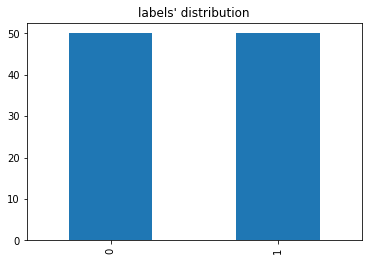

In [20]:
import matplotlib.pyplot as plt

percentages = round(df["clickbait"].value_counts()*100/len(df), 1)
percentages.plot(kind="bar", title="labels' distribution")

plt.show()

So the labels are equaly distributed.

In [0]:
text_train_val, text_test, label_train_val, label_test = train_test_split(
    df["headline"], 
    df["clickbait"], 
    test_size=0.25, 
    stratify=df["clickbait"], 
    random_state=9)

# Split the train_val dataset to train and validation separete portions.
text_train, text_val, label_train, label_val = train_test_split(
    text_train_val,
    label_train_val, 
    test_size=0.2, 
    random_state=9)

In [22]:
print(text_train.shape, text_val.shape, label_test.shape)

(19200,) (4800,) (8000,)


Read the USE pretrained network and add an output layer at the end, then, fine-tune the weights of the new network.

In [9]:
input = tf.keras.layers.Input(shape=[], dtype=tf.string)
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True)(input)
output = tf.keras.layers.Dense(1, activation="sigmoid")(use)
model = tf.keras.models.Model(input, output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 256,798,337
Trainable params: 256,798,337
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["accuracy"])

So let's fine-tune the USE weights..

In [12]:
%%time
model.fit(text_train, 
          label_train,
          epochs=2,
          validation_data=(text_val, label_val),
          verbose=2)

Epoch 1/2
600/600 - 1385s - loss: 0.1094 - accuracy: 0.9716 - val_loss: 0.0465 - val_accuracy: 0.9854
Epoch 2/2
600/600 - 1378s - loss: 0.0154 - accuracy: 0.9958 - val_loss: 0.0477 - val_accuracy: 0.9840
CPU times: user 1h 27min 56s, sys: 1min 48s, total: 1h 29min 45s
Wall time: 46min 15s


In [52]:
label_preds = model.predict(text_train)
label_preds

array([[0.99799895],
       [0.0020186 ],
       [0.00471288],
       ...,
       [0.00205421],
       [0.9979954 ],
       [0.00211179]], dtype=float32)

Converting the probablities to lables.

In [53]:
label_preds_classes = np.round(label_preds)
label_preds_classes

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [46]:
train_metrics = metrics.classification_report(label_train, label_preds_classes, labels=[0, 1], digits=4)
print(train_metrics)

              precision    recall  f1-score   support

           0     0.9999    0.9998    0.9998      9627
           1     0.9998    0.9999    0.9998      9573

    accuracy                         0.9998     19200
   macro avg     0.9998    0.9998    0.9998     19200
weighted avg     0.9998    0.9998    0.9998     19200



In [45]:
label_preds_classes_test = np.round(model.predict(text_test))
test_metrics = metrics.classification_report(label_test, label_preds_classes_test, labels=[0, 1], digits=4)
print(test_metrics)

              precision    recall  f1-score   support

           0     0.9889    0.9792    0.9840      4000
           1     0.9795    0.9890    0.9842      4000

    accuracy                         0.9841      8000
   macro avg     0.9842    0.9841    0.9841      8000
weighted avg     0.9842    0.9841    0.9841      8000



As you can see, the macro precision on the test set is `0.9842`.